In [ ]:
# https://huggingface.co/spaces/skytnt/anime-aesthetic-predict/blob/main/app.py

In [15]:
import cv2
import glob
import os
import numpy as np
import onnxruntime as rt
from PIL import Image
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

In [3]:
model_path = hf_hub_download(repo_id="skytnt/anime-aesthetic", filename="model.onnx")
model = rt.InferenceSession(model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

model.onnx:   0%|          | 0.00/112M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [5]:
def predict(img_path):
    img = cv2.imread(img_path)
    img = img.astype(np.float32) / 255
    s = 768
    h, w = img.shape[:-1]
    h, w = (s, int(s * w / h)) if h > w else (int(s * h / w), s)
    ph, pw = s - h, s - w
    img_input = np.zeros([s, s, 3], dtype=np.float32)
    img_input[ph // 2:ph // 2 + h, pw // 2:pw // 2 + w] = cv2.resize(img, (w, h))
    img_input = np.transpose(img_input, (2, 0, 1))
    img_input = img_input[np.newaxis, :]
    pred = model.run(None, {"img": img_input})[0].item()
    return pred


In [6]:
predict("aesthetics_toy_images/anime/acertain_0.png")

0.1992589831352234

anime_0
acertain_0.png: 0.1992589831352234
animagine_xl_31_0.png: 0.13136173784732819
anime_pastel_dream_0.png: 0.3109036684036255
anythingv5_0.png: 0.7221370339393616
dall_e_2_0.png: 0.20888665318489075
dall_e_3_0.png: 0.6739991307258606
sd15_0.png: 0.15122252702713013
sd21_0.png: 0.060691941529512405
sdxl_0.png: 0.1866547167301178

anime_1
acertain_1.png: 0.13487155735492706
animagine_xl_31_1.png: 0.10620728135108948
anime_pastel_dream_1.png: 0.42955389618873596
anythingv5_1.png: 0.2890012264251709
dall_e_2_1.png: 0.12389576435089111
dall_e_3_1.png: 0.9146471619606018
sd15_1.png: 0.14305146038532257
sd21_1.png: 0.059171147644519806
sdxl_1.png: 0.7650423049926758

real_0
acertain_0.png: 0.1421559453010559
animagine_xl_31_0.png: 0.17403647303581238
anime_pastel_dream_0.png: 0.2675345838069916
anythingv5_0.png: 0.04786483198404312
dall_e_2_0.png: 0.07437780499458313
dall_e_3_0.png: 0.0733485147356987
sd15_0.png: 0.1144164577126503
sd21_0.png: 0.31017571687698364
sdxl_0.png: 0.0512461848

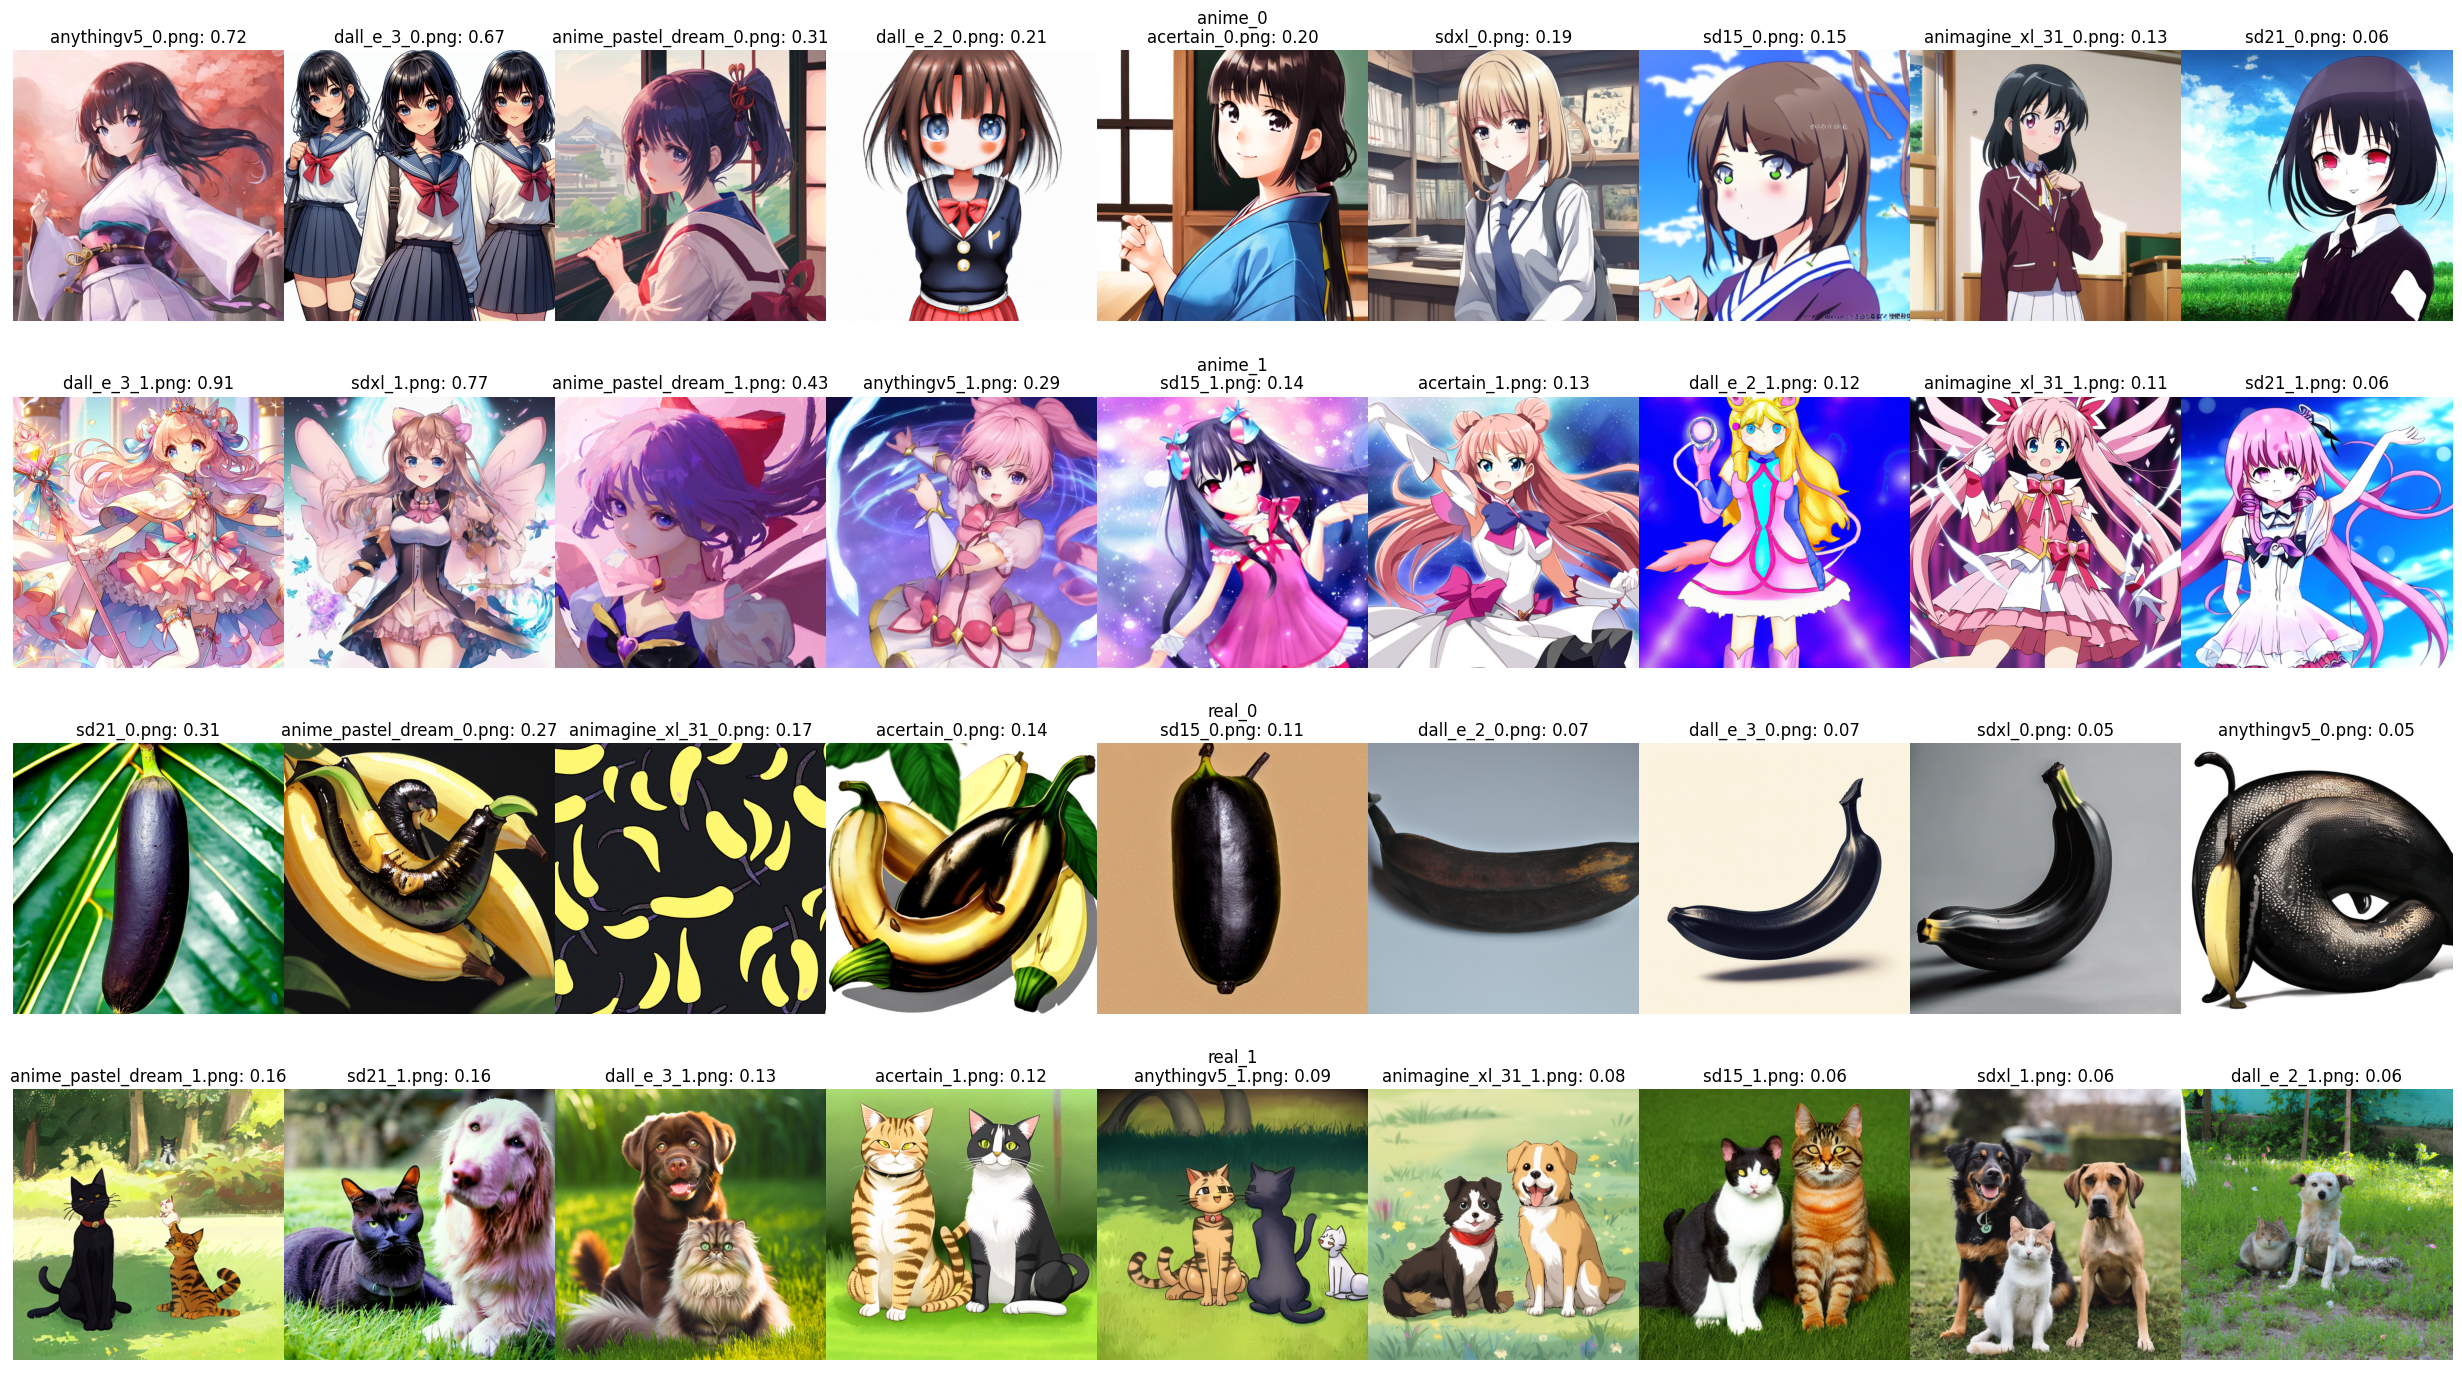

In [16]:
score_data = {}
image_root_dir = "aesthetics_toy_images"
subdirs = sorted(glob.glob(f"{image_root_dir}/*"))
for subdir in subdirs:
    for i in range(2):
        subdir_key = f"{os.path.basename(subdir)}_{i}"
        print(subdir_key)
        files = sorted(glob.glob(subdir+f"/*{i}.png"))
        score_data[subdir_key] = {}
        for file in files:
            prediction = predict(file)
            score_data[subdir_key][os.path.basename(file)] = prediction
            print(f'{os.path.basename(file)}: {prediction}')
        print()

# Plot
fig, axes = plt.subplots(len(score_data), 1, figsize=(25, 3.5 * len(score_data)))

# 各ケースごとにスコアを降順ソートして画像を表示
for i, (case, scores) in enumerate(score_data.items()):
    sorted_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    images = [Image.open(os.path.join(image_root_dir, case.split("_")[0], img)) for img, score in sorted_scores]
    filenames = [img for img, score in sorted_scores]
    scores = [score for img, score in sorted_scores]
    
    ax = axes[i] if len(score_data) > 1 else axes
    for j, (image, filename, score) in enumerate(zip(images, filenames, scores)):
        ax_sub = ax.inset_axes([j/len(images), 0, 1/len(images), 1], transform=ax.transAxes)
        ax_sub.imshow(image)
        ax_sub.set_title(f'{filename}: {score:.2f}')
        ax_sub.axis('off')
    ax.set_title(case)
    ax.axis('off')

plt.tight_layout()
plt.savefig("anime_aesthetic_score_predictor.png")
plt.show()    